# **Bibliotecas**

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pmdarima as pm

import warnings



# **Importação dos dados**

In [2]:
# lendo os dados
INPUT_DIR = 'C:/Users/Igor/Desktop/PIBIC 2021 e 2022/Dados'

calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv') #sales_train d_1 até d_1913
sales_train_eva = pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv') #sales_train d_1 até d_1941

# NOTE: o banco sales_train_eva contempla o sales_train_val e ainda adciona observações das vendas dos dias d_1914 - d_1941

# **Análise exploratória dos dados**

In [3]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [4]:
selling_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [5]:
sample_submission


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
sales_train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [7]:
sales_train_eva

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


## **Construção dos dicionários (filtros) para evaluation**

In [114]:
### Dicionário 12 - Sales of product x, aggregated for each store
dict_12_eva = {} # número de vendas diárias do produto x, agregado por cada loja (dia 1 até dia 1941) 

stores = list(np.unique(sales_train_eva['store_id'].values))
products = list(np.unique(sales_train_eva['item_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))

for store in stores:
    
    for product in products:
        
        b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['item_id'] == product) &
        (sales_train_eva['store_id'] == store)].groupby(['store_id', 'item_id']).sum()), np.array([np.nan]*28)), axis = None)[0:1941]
        
        dict_12_eva[str(product)+'_'+ str(store)+'_evaluation'] = pd.Series(b, index = pd.to_datetime(calendar['date'][0:1941])).asfreq('D')


### Dicionário 11 - Sales of product x, aggregated for each State
dict_11_eva = {} # número de vendas diárias do produto x, agregado por cada Estado (dia 1 até dia 1941)

states = list(np.unique(sales_train_eva['state_id'].values))
products = list(np.unique(sales_train_eva['item_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))

for state in states:
    
    for product in products:
        
        b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['item_id'] == product) &
        (sales_train_eva['state_id'] == state)].groupby(['item_id', 'state_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1941]
        
        dict_11_eva[str(product)+'_'+ str(state)] = pd.Series(b, index = calendar['date'][0:1941])
             

### Dicionário 10 - Sales of product x, aggregated for all stores/states
dict_10_eva = {} # número de vendas diárias do produto x, agregado para todas as lojas e Estados (dia 1 até dia 1941)

products = list(np.unique(sales_train_eva['item_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

    
for product in products:
    
    b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['item_id'] == product)].groupby(['item_id'])[a].sum()), np.array([np.nan]*28)),
    axis = None)[0:1941]
        
    dict_10_eva[str(product)] = pd.Series(b, index = calendar['date'][0:1941])
    


### Dicionário 9 - Sales of all products, aggregated for each store and department
dict_9_eva = {} # número de vendas diárias de todos produtos, agregado por cada loja e departamento (dia 1 até dia 1941)

departaments = list(np.unique(sales_train_eva['dept_id'].values))
stores = list(np.unique(sales_train_eva['store_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

for store in stores:
    
    for departament in departaments:
        
        b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['dept_id'] == departament) &
        (sales_train_eva['store_id'] == store)].groupby(['store_id', 'dept_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1941]
        
        dict_9_eva[str(store)+'_'+str(departament)] = pd.Series(b, index = pd.to_datetime(calendar['date'][0:1941])).asfreq('D')



### Dicionário 8 - sales of all products, aggregated for each store and category
dict_8_eva = {} # número de vendas diárias de todos produtos, agregado por cada loja e categoria (dia 1 até dia 1941)

categories = list(np.unique(sales_train_eva['cat_id'].values))
stores = list(np.unique(sales_train_eva['store_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

for store in stores:
    
    for category in categories:
        
        b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['cat_id'] == category) &
        (sales_train_eva['store_id'] == store)].groupby(['store_id', 'cat_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1941]
        
        dict_8_eva[str(store)+'_'+str(category)] = pd.Series(b, index = calendar['date'][0:1941])
        
        

### Dicionário 7 - sales of all products, aggregated for each State and department
dict_7_eva = {} # número de vendas diárias de todos produtos, agregado por cada Estado e departamento (dia 1 até dia 1941)

states = list(np.unique(sales_train_eva['state_id'].values))
departaments = list(np.unique(sales_train_eva['dept_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

for state in states:
    
    for departament in departaments:
        
        b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['state_id'] == state) &
        (sales_train_eva['dept_id'] == departament)].groupby(['state_id', 'dept_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1941]
        
        dict_7_eva[str(state)+'_'+str(departament)] = pd.Series(b, index = calendar['date'][0:1941])
        
        

### Dicionário 6 - sales of all products, aggregated for each State and category
dict_6_eva = {} # número de vendas diárias de todos produtos, agregado por cada Estado e categoria (dia 1 até dia 1941)

states = list(np.unique(sales_train_eva['state_id'].values))
categories = list(np.unique(sales_train_eva['cat_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

for state in states:
    
    for category in categories:
        
        b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['state_id'] == state) &
        (sales_train_eva['cat_id'] == category)].groupby(['state_id', 'cat_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1941]
        
        dict_6_eva[str(state)+'_'+str(category)] = pd.Series(b, index = calendar['date'][0:1941])
        
        

### Dicionário 5 - sales of all products, aggregated for each department
dict_5_eva = {} # número de vendas diárias de todos produtos, agregado por cada departamneto (dia 1 até dia 1941)

departaments = list(np.unique(sales_train_eva['dept_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

for departament in departaments:
    
    b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['dept_id'] == departament)].groupby(['dept_id'])[a].sum()),
    np.array([np.nan]*28)), axis = None)[0:1941]
    
    dict_5_eva[str(departament)] = pd.Series(b, index = calendar['date'][0:1941])
        
        

### Dicionário 4 - sales of all products, aggregated for each category
dict_4_eva = {} # número de vendas diárias de todos produtos, agregado por categoria (dia 1 até dia 1941)

categories = list(np.unique(sales_train_eva['cat_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

for category in categories:
    
    b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['cat_id'] == category)].groupby(['cat_id'])[a].sum()), np.array([np.nan]*28)),
    axis = None)[0:1941]
    
    dict_4_eva[str(category)] = pd.Series(b, index = calendar['date'][0:1941])
        
        

### Dicionário 3 - sales of all products, aggregated for each store
dict_3_eva = {} # número de vendas diárias de todos produtos, agregado por cada loja (dia 1 até dia 1941)

stores = list(np.unique(sales_train_eva['store_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

for store in stores:
    
    b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['store_id'] == store)].groupby(['store_id'])[a].sum()), np.array([np.nan]*28)),
    axis = None)[0:1941]
    
    dict_3_eva[str(store)] = pd.Series(b, index = calendar['date'][0:1941])
        
        

### Dicionário 2 - sales of all products, aggregated for each State
dict_2_eva = {} # número de vendas diárias de todos produtos, agregado por cada Estado (dia 1 até dia 1941)

states = list(np.unique(sales_train_eva['state_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

for state in states:
    
    b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['state_id'] == state)].groupby(['state_id'])[a].sum()), np.array([np.nan]*28)),
    axis = None)[0:1941]
    
    dict_2_eva[str(state)] = pd.Series(b, index = calendar['date'][0:1941])
        
        
### Dicionário 1 - sales of all products, aggregated for all stores/states
dict_1_eva = {} # número de vendas diárias de todos produtos sem hierarquia (dia 1 até dia 1941)


a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    
data1 = sales_train_eva
data1['sales_filter'] = np.array(['none']*len(sales_train_eva))

b = np.concatenate((np.array(data1.groupby(['sales_filter'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1941]

dict_1_eva['all'] = pd.Series(b, index = calendar['date'][0:1941])
        

In [9]:
print(len(dict_1_eva) + len(dict_2_eva) + len(dict_3_eva) + len(dict_4_eva)+ len(dict_5_eva) + len(dict_6_eva)
+ len(dict_7_eva)+ len(dict_8_eva) + len(dict_9_eva)
+ len(dict_10_eva) + len(dict_11_eva)+ len(dict_12_eva))

42840


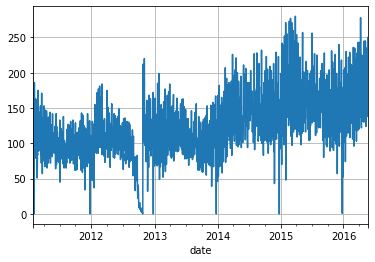

In [10]:
dict_9_eva['WI_1_HOUSEHOLD_2'].index = pd.to_datetime(dict_9_eva['WI_1_HOUSEHOLD_2'].index)

dict_9_eva['WI_1_HOUSEHOLD_2'].plot(grid = True)
plt.show()

## **Construção dos dicionários (filtros) para validation**

In [119]:
### Dicionário 12 - Sales of product x, aggregated for each store
dict_12_val = {} # número de vendas diárias do produto x, agregado por cada loja (dia 1 até dia 1913) 

stores = list(np.unique(sales_train_val['store_id'].values))
products = list(np.unique(sales_train_val['item_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))

for store in stores:
    
    for product in products:
        
        b = np.concatenate((np.array(sales_train_val[(sales_train_val['item_id'] == product) &
        (sales_train_val['store_id'] == store)].groupby(['store_id', 'item_id']).sum()), np.array([np.nan]*28)), axis = None)[0:1913]
        
        dict_12_val[str(product)+'_'+ str(store)+'_validation'] = pd.Series(b, index = pd.to_datetime(calendar['date'][0:1913])).asfreq('D')


### Dicionário 11 - Sales of product x, aggregated for each State
dict_11_val = {} # número de vendas diárias do produto x, agregado por cada Estado (dia 1 até dia 1913)

states = list(np.unique(sales_train_val['state_id'].values))
products = list(np.unique(sales_train_val['item_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))

for state in states:
    
    for product in products:
        
        b = np.concatenate((np.array(sales_train_val[(sales_train_val['item_id'] == product) &
        (sales_train_val['state_id'] == state)].groupby(['item_id', 'state_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1913]
        
        dict_11_val[str(product)+'_'+ str(state)] = pd.Series(b, index = calendar['date'][0:1913])
             

### Dicionário 10 - Sales of product x, aggregated for all stores/states
dict_10_val = {} # número de vendas diárias do produto x, agregado para todas as lojas e Estados (dia 1 até dia 1913)

products = list(np.unique(sales_train_val['item_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    

    
for product in products:
    
    b = np.concatenate((np.array(sales_train_val[(sales_train_val['item_id'] == product)].groupby(['item_id'])[a].sum()), np.array([np.nan]*28)),
    axis = None)[0:1913]
        
    dict_10_val[str(product)] = pd.Series(b, index = calendar['date'][0:1913])
    


### Dicionário 9 - Sales of all products, aggregated for each store and department
dict_9_val = {} # número de vendas diárias de todos produtos, agregado por cada loja e departamento (dia 1 até dia 1913)

departaments = list(np.unique(sales_train_val['dept_id'].values))
stores = list(np.unique(sales_train_val['store_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    

for store in stores:
    
    for departament in departaments:
        
        b = np.concatenate((np.array(sales_train_val[(sales_train_val['dept_id'] == departament) &
        (sales_train_val['store_id'] == store)].groupby(['store_id', 'dept_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1913]
        
        dict_9_val[str(store)+'_'+str(departament)] = pd.Series(b, index = pd.to_datetime(calendar['date'][0:1913])).asfreq('D')



### Dicionário 8 - sales of all products, aggregated for each store and category
dict_8_val = {} # número de vendas diárias de todos produtos, agregado por cada loja e categoria (dia 1 até dia 1913)

categories = list(np.unique(sales_train_val['cat_id'].values))
stores = list(np.unique(sales_train_val['store_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    

for store in stores:
    
    for category in categories:
        
        b = np.concatenate((np.array(sales_train_val[(sales_train_val['cat_id'] == category) &
        (sales_train_val['store_id'] == store)].groupby(['store_id', 'cat_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1913]
        
        dict_8_val[str(store)+'_'+str(category)] = pd.Series(b, index = calendar['date'][0:1913])
        
        

### Dicionário 7 - sales of all products, aggregated for each State and department
dict_7_val = {} # número de vendas diárias de todos produtos, agregado por cada Estado e departamento (dia 1 até dia 1913)

states = list(np.unique(sales_train_val['state_id'].values))
departaments = list(np.unique(sales_train_val['dept_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    

for state in states:
    
    for departament in departaments:
        
        b = np.concatenate((np.array(sales_train_val[(sales_train_val['state_id'] == state) &
        (sales_train_val['dept_id'] == departament)].groupby(['state_id', 'dept_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1913]
        
        dict_7_val[str(state)+'_'+str(departament)] = pd.Series(b, index = calendar['date'][0:1913])
        
        

### Dicionário 6 - sales of all products, aggregated for each State and category
dict_6_val = {} # número de vendas diárias de todos produtos, agregado por cada Estado e categoria (dia 1 até dia 1913)

states = list(np.unique(sales_train_val['state_id'].values))
categories = list(np.unique(sales_train_val['cat_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    

for state in states:
    
    for category in categories:
        
        b = np.concatenate((np.array(sales_train_val[(sales_train_val['state_id'] == state) &
        (sales_train_val['cat_id'] == category)].groupby(['state_id', 'cat_id'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1913]
        
        dict_6_val[str(state)+'_'+str(category)] = pd.Series(b, index = calendar['date'][0:1913])
        
        

### Dicionário 5 - sales of all products, aggregated for each department
dict_5_val = {} # número de vendas diárias de todos produtos, agregado por cada departamneto (dia 1 até dia 1913)

departaments = list(np.unique(sales_train_val['dept_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    

for departament in departaments:
    
    b = np.concatenate((np.array(sales_train_val[(sales_train_val['dept_id'] == departament)].groupby(['dept_id'])[a].sum()),
    np.array([np.nan]*28)), axis = None)[0:1913]
    
    dict_5_val[str(departament)] = pd.Series(b, index = calendar['date'][0:1913])
        
        

### Dicionário 4 - sales of all products, aggregated for each category
dict_4_val = {} # número de vendas diárias de todos produtos, agregado por categoria (dia 1 até dia 1913)

categories = list(np.unique(sales_train_val['cat_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    

for category in categories:
    
    b = np.concatenate((np.array(sales_train_val[(sales_train_val['cat_id'] == category)].groupby(['cat_id'])[a].sum()),
    np.array([np.nan]*28)), axis = None)[0:1913]
    
    dict_4_val[str(category)] = pd.Series(b, index = calendar['date'][0:1913])
        
        

### Dicionário 3 - sales of all products, aggregated for each store
dict_3_val = {} # número de vendas diárias de todos produtos, agregado por cada loja (dia 1 até dia 1913)

stores = list(np.unique(sales_train_val['store_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    

for store in stores:
    
    b = np.concatenate((np.array(sales_train_val[(sales_train_eva['store_id'] == store)].groupby(['store_id'])[a].sum()),
    np.array([np.nan]*28)), axis = None)[0:1913]
    
    dict_3_val[str(store)] = pd.Series(b, index = calendar['date'][0:1913])
        
        

### Dicionário 2 - sales of all products, aggregated for each State
dict_2_val = {} # número de vendas diárias de todos produtos, agregado por cada Estado (dia 1 até dia 1913)

states = list(np.unique(sales_train_val['state_id'].values))

a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    

for state in states:
    
    b = np.concatenate((np.array(sales_train_val[(sales_train_val['state_id'] == state)].groupby(['state_id'])[a].sum()), np.array([np.nan]*28)),
    axis = None)[0:1913]
    
    dict_2_val[str(state)] = pd.Series(b, index = calendar['date'][0:1913])
        
        
### Dicionário 1 - sales of all products, aggregated for all stores/states
dict_1_val = {} # número de vendas diárias de todos produtos sem hierarquia (dia 1 até dia 1913)


a = []
for i in range(1913):
    a.append('d_' +str(i+1))
    
data1 = sales_train_val
data1['sales_filter'] = np.array(['none']*len(sales_train_val))

b = np.concatenate((np.array(data1.groupby(['sales_filter'])[a].sum()), np.array([np.nan]*28)), axis = None)[0:1913]

dict_1_val['all'] = pd.Series(b, index = calendar['date'][0:1913])

In [12]:
print(len(dict_1_val) + len(dict_2_val) + len(dict_3_val) + len(dict_4_val)+ len(dict_5_val) + len(dict_6_val)
+ len(dict_7_val)+ len(dict_8_val)+ len(dict_9_val)
+ len(dict_10_val) + len(dict_11_val)+ len(dict_12_val))

42840


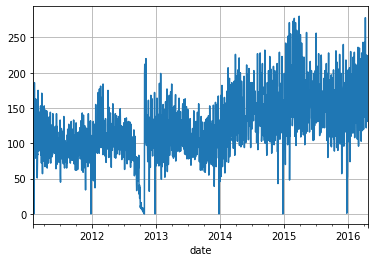

In [13]:
dict_9_val['WI_1_HOUSEHOLD_2'].index = pd.to_datetime(dict_9_val['WI_1_HOUSEHOLD_2'].index)

dict_9_val['WI_1_HOUSEHOLD_2'].plot(grid = True)
plt.show()

## **Construção da função para agregar os dados dos múltiplos bancos da competição (attach_datas(.)) validation**


In [125]:
def attach_datas_val(filtro, store_id, dept_id):
    '''Função que retorna um data frame com as informações de calendar.csv, sell_prices.csv e
    sales_train_validation.csv dado dict_9_val[store_id_dept_id] como entrada
    
    Argumentos:
    
    filtro pode assumir qualquer valor dentro do dict_9_val;
    store_id é uma string do id da loja;
    dept_id é uma string do id do departamento.
    
    '''
    b = pd.DataFrame(calendar.loc[0:1940, ])
    b['#sales'] = np.concatenate((np.array(filtro), np.array([np.nan]*28)), axis = None)

    selling_prices['id'] = selling_prices['item_id'] + '_' + selling_prices['store_id'] + '_validation'
    
    c = selling_prices[selling_prices['id'].isin([i for i in sales_train_val['id'] if ((store_id in i) & 
    (dept_id in i))])][selling_prices['wm_yr_wk'] <= 11617].groupby('wm_yr_wk').mean() 
        
    m = pd.merge(b, c, how = 'outer', on = 'wm_yr_wk')

    m['date'] = pd.to_datetime(m['date'])

    m.set_index('date', inplace = True)

    m.rename(columns={'sell_price':'media_preco_de_venda'}, inplace = True)

    m['filtro'] = str(dept_id) + '_' + str(store_id) + '_validation'
    
    return pd.get_dummies(m, dummy_na= True, columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'])

In [144]:
warnings.filterwarnings("ignore")

attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')

,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,#sales,...,event_type_1_Sporting,event_type_1_nan,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_name_2_nan,event_type_2_Cultural,event_type_2_Religious,event_type_2_nan
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,148.0,...,0,1,0,0,0,0,1,0,0,1
2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,151.0,...,0,1,0,0,0,0,1,0,0,1
2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,66.0,...,0,1,0,0,0,0,1,0,0,1
2011-02-01,11101,Tuesday,4,2,2011,d_4,1,1,0,47.0,...,0,1,0,0,0,0,1,0,0,1
2011-02-02,11101,Wednesday,5,2,2011,d_5,1,0,1,0.0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,11616,Wednesday,5,5,2016,d_1937,0,0,0,NaN,...,0,1,0,0,0,0,1,0,0,1
2016-05-19,11616,Thursday,6,5,2016,d_1938,0,0,0,NaN,...,0,1,0,0,0,0,1,0,0,1
2016-05-20,11616,Friday,7,5,2016,d_1939,0,0,0,NaN,...,0,1,0,0,0,0,1,0,0,1


In [147]:
attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').columns

Index(['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'snap_CA',
       'snap_TX', 'snap_WI', '#sales', 'media_preco_de_venda', 'filtro',
       'event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_Supe

## **Construção da função para agregar os dados dos múltiplos bancos da competição (attach_datas(.)) evaluation**

In [131]:
def attach_datas_eva(filtro, store_id, dept_id):
    '''Função que retorna um data frame com as informações de calendar.csv, sell_prices.csv e
    sales_train_evaluation.csv dado dict_9_val[store_id_dept_id] como entrada
    
    Argumentos:
    
    filtro pode assumir qualquer valor dentro do dict_9_eva;
    store_id é uma string do id da loja;
    dept_id é uma string do id do departamento.
    
    '''
    
    b = calendar
    b['#sales'] = np.concatenate((np.array(filtro), np.array([np.nan]*28)), axis = None)

    selling_prices['id'] = selling_prices['item_id'] + '_' + selling_prices['store_id'] + '_evaluation'
    
    c = selling_prices[selling_prices['id'].isin([i for i in sales_train_eva['id'] if ((store_id in i) & 
    (dept_id in i))])].groupby('wm_yr_wk').mean()
        
    m = pd.merge(b, c, how = 'outer', on = 'wm_yr_wk')

    m['date'] = pd.to_datetime(m['date'])

    m.set_index('date', inplace = True)

    m.rename(columns={'sell_price':'media_preco_de_venda'}, inplace = True)

    m['filtro'] = str(dept_id) + '_' + str(store_id) + '_evaluation'

    
    return pd.get_dummies(m, dummy_na= True, columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'])

In [192]:
warnings.filterwarnings("ignore")

attach_datas_eva(dict_9_eva['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')

,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,#sales,...,event_type_1_Sporting,event_type_1_nan,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_name_2_nan,event_type_2_Cultural,event_type_2_Religious,event_type_2_nan
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,148.0,...,0,1,0,0,0,0,1,0,0,1
2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,151.0,...,0,1,0,0,0,0,1,0,0,1
2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,66.0,...,0,1,0,0,0,0,1,0,0,1
2011-02-01,11101,Tuesday,4,2,2011,d_4,1,1,0,47.0,...,0,1,0,0,0,0,1,0,0,1
2011-02-02,11101,Wednesday,5,2,2011,d_5,1,0,1,0.0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,11620,Wednesday,5,6,2016,d_1965,0,1,1,NaN,...,0,1,0,0,0,0,1,0,0,1
2016-06-16,11620,Thursday,6,6,2016,d_1966,0,0,0,NaN,...,0,1,0,0,0,0,1,0,0,1
2016-06-17,11620,Friday,7,6,2016,d_1967,0,0,0,NaN,...,0,1,0,0,0,0,1,0,0,1


##  **AJUSTE DOS MODELOS**

### RASCUNHO - STEPWISE PARA EXOG = 


In [210]:
e1 = attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')[['wday', 'media_preco_de_venda', 'snap_WI']][0:1913]
a =  1 - (np.array(attach_datas_eva(dict_9_eva['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['event_name_1_nan'])*
np.array(attach_datas_eva(dict_9_eva['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['event_name_2_nan']))
a = pd.Series(a, index = attach_datas_eva(dict_9_eva['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').index)
e1['evento'] = a.shift(-7)[0:1913]



warnings.filterwarnings("ignore")

model = sm.tsa.arima.ARIMA(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['#sales'][0:1913], exog= e1,order=(1,1,2))
result = model.fit()

result.bic

18309.35906713523

In [196]:
e1 = attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')[['wday', 'media_preco_de_venda', 'snap_WI']][0:1913]
e1['evento'] =  1 - (np.array(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['event_name_1_nan'][0:1913])*
np.array(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['event_name_2_nan'][0:1913]))



warnings.filterwarnings("ignore")

model = sm.tsa.arima.ARIMA(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['#sales'][0:1913], exog= e1,order=(1,1,2))
result = model.fit()

result.bic

18273.57435420505

In [175]:
warnings.filterwarnings("ignore")

model = sm.tsa.arima.ARIMA(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['#sales'][0:1913], exog= attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')[['wday', 'media_preco_de_venda']][0:1913],order=(1,1,2))
result = model.fit()
result.bic

18303.145371048948

In [176]:
warnings.filterwarnings("ignore")

model = sm.tsa.arima.ARIMA(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['#sales'][0:1913], exog= attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')[['wday', 'media_preco_de_venda','snap_WI']][0:1913],order=(1,1,2))
result = model.fit()
result.bic

18309.109630263105

In [184]:
e1 = attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').drop(['wm_yr_wk', 'weekday', 'filtro', '#sales','d'], axis = 1)[0:1913]


e2 = attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').drop(['wm_yr_wk', 'weekday', 'filtro', '#sales','d'], axis = 1)[1913:1941]


model = sm.tsa.arima.ARIMA(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['#sales'][0:1913], exog= e1,order=(1,2,1))
result = model.fit()
result.bic

19043.42551355868

In [185]:
warnings.filterwarnings("ignore")

model = sm.tsa.arima.ARIMA(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['#sales'][0:1913], exog= attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').drop(['wm_yr_wk', 'weekday','year', 'd', '#sales','filtro', 'month'], axis = 1)[0:1913],order=(1,1,2))
result = model.fit()

result.bic


18453.044007264354

In [195]:
e1 = attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')[['wday', 'media_preco_de_venda', 'snap_WI']][0:1913]
e1['evento'] =  1 - (np.array(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['event_name_1_nan'][0:1913])*
np.array(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['event_name_2_nan'][0:1913]))



warnings.filterwarnings("ignore")

model = sm.tsa.arima.ARIMA(attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['#sales'][0:1913], exog= e1,order=(1,1,2))
result = model.fit()

result.bic

18273.57435420505

In [193]:
attach_datas_eva(dict_9_eva['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').columns

Index(['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'snap_CA',
       'snap_TX', 'snap_WI', '#sales', 'media_preco_de_venda', 'filtro',
       'event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_Supe

In [ ]:
# DESCENDO NO NIVEL DE AGREGACAO ATÉ O NIVEL MAIS BAIXO A PARTIR DA PREVISÃO COM DICT_9

round((dict_12_eva['FOODS_1_001_CA_1_evaluation'].sum()/dict_9_eva['CA_1_FOODS_1'].sum())*297, 0)

In [186]:
attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['media_preco_de_venda']

date
2011-01-29    5.723961
2011-01-30    5.723961
2011-01-31    5.723961
2011-02-01    5.723961
2011-02-02    5.723961
                ...   
2016-05-18    5.778777
2016-05-19    5.778777
2016-05-20    5.778777
2016-05-21    5.775689
2016-05-22    5.775689
Name: media_preco_de_venda, Length: 1941, dtype: float64

In [160]:
attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['media_preco_de_venda'].shift(-7)

date
2011-01-29    5.917419
2011-01-30    5.917419
2011-01-31    5.917419
2011-02-01    5.917419
2011-02-02    5.917419
                ...   
2016-05-18         NaN
2016-05-19         NaN
2016-05-20         NaN
2016-05-21         NaN
2016-05-22         NaN
Name: media_preco_de_venda, Length: 1941, dtype: float64